# Aprimorando o modelo de regressão

---

O post e modelo inicial está neste [link](https://github.com/barbosarafael/Projetos/blob/master/House%20Prices%20-%20Advanced%20Regression%20Techniques/notebook_house_prices.ipynb) no github.

Aqui iremos melhorar o workflow e utilizaremos o `pipeline` do `sklearn` para deixar mais simples os processos.

# Bibliotecas utilizadas

---

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import pipeline

plt.style.use("seaborn-muted")
%matplotlib inline

# Baixando os dados 

---

In [87]:
treino = pd.read_csv(filepath_or_buffer = "train.csv")
teste = pd.read_csv(filepath_or_buffer = "test.csv")

# Manuseio nos dados

---

## Colocando em uma variável separada

In [88]:
var_venda = treino["SalePrice"]

## Concatenando os dados de treino e teste

In [89]:
treino.drop(["SalePrice"], axis = 1, inplace = True)

In [90]:
treino_index = treino.shape[0]

In [91]:
teste_index = teste.shape[0]

In [92]:
banco_geral = pd.concat(objs = [treino, teste], axis = 0).reset_index(drop = True)

banco_geral

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


## Dados nulos

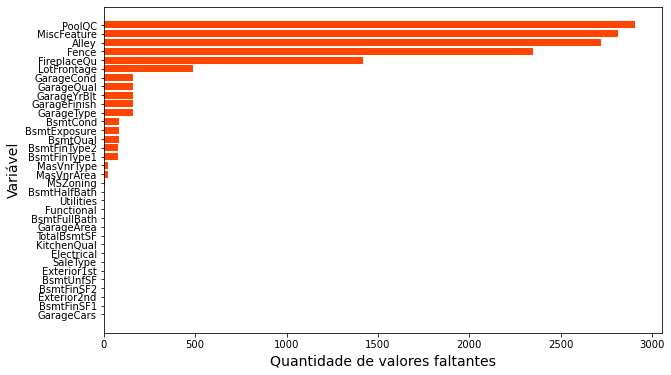

In [93]:
miss_val = banco_geral.isnull().sum().sort_values(ascending = False)

dados_miss_val = pd.DataFrame(miss_val)

dados_miss_val = dados_miss_val.reset_index()

dados_miss_val.columns = ["Variável", "Quantidade"]

dados_miss_val = dados_miss_val[dados_miss_val["Quantidade"] > 0].sort_values(by = "Quantidade")

#-------------------------

plt.figure(figsize = [10, 6])
plt.barh(dados_miss_val["Variável"], dados_miss_val["Quantidade"], align = "center", color = "orangered")
plt.xlabel("Quantidade de valores faltantes", fontsize = 14, color = "black")
plt.ylabel("Variável", fontsize = 14, color = "black")
plt.tick_params(axis = "x", labelcolor = "black")
plt.tick_params(axis = "y", labelcolor = "black")
plt.show()

---

Vamos exlcuir as top5 variáveis que mais possuem valores faltantes.

In [94]:
banco_geral = banco_geral.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis = 1)

banco_geral.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,84,0,0,0,0,0,12,2008,WD,Normal


## Variáveis quantitativas 

---

### Selecionando as variáveis úteis

In [95]:
banco_geral_quant = banco_geral[["YearBuilt", "YearRemodAdd", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "FullBath", "TotRmsAbvGrd", "GarageArea"]]

banco_geral_quant.head()

,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageArea
0,2003,2003,856.0,856,1710,2,8,548.0
1,1976,1976,1262.0,1262,1262,2,6,460.0
2,2001,2002,920.0,920,1786,2,6,608.0
3,1915,1970,756.0,961,1717,1,7,642.0
4,2000,2000,1145.0,1145,2198,2,9,836.0


### Normalização em algumas delas 

In [96]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

banco_geral_quant[["TotalBsmtSF", "1stFlrSF", "GrLivArea", "GarageArea"]] = scaler.fit_transform(banco_geral_quant[["TotalBsmtSF", "1stFlrSF", "GrLivArea", "GarageArea"]])

banco_geral_quant.head()

C:\Users\Rafael\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Rafael\miniconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageArea
0,2003,2003,-0.444252,-0.773861,0.413547,2,8,0.348840
1,1976,1976,0.477029,0.261075,-0.471891,2,6,-0.059782
2,2001,2002,-0.299025,-0.610718,0.563755,2,6,0.627446
3,1915,1970,-0.671168,-0.506205,0.427382,1,7,0.785323
4,2000,2000,0.211537,-0.037170,1.378042,2,9,1.686149


## Trocar tipo de variáveis

---

In [97]:
banco_geral["MSSubClass"] = banco_geral["MSSubClass"].astype(str)
banco_geral["OverallQual"] = banco_geral["OverallQual"].astype(str)
banco_geral["OverallCond"] = banco_geral["OverallCond"].astype(str)

## Selecionando as variáveis qualitativas 

---

In [98]:
banco_geral_qualit = banco_geral.select_dtypes("object")

banco_geral_qualit.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [99]:
banco_geral_qualit = banco_geral_qualit[["LotShape", "LandContour", "LandSlope", "LotConfig", "HouseStyle", "HeatingQC", "OverallQual"]]

banco_geral_qualit.head()

,LotShape,LandContour,LandSlope,LotConfig,HouseStyle,HeatingQC,OverallQual
0,Reg,Lvl,Gtl,Inside,2Story,Ex,7
1,Reg,Lvl,Gtl,FR2,1Story,Ex,6
2,IR1,Lvl,Gtl,Inside,2Story,Ex,7
3,IR1,Lvl,Gtl,Corner,2Story,Gd,7
4,IR1,Lvl,Gtl,FR2,2Story,Ex,8


In [100]:
banco_geral_qualit = pd.get_dummies(banco_geral_qualit)

banco_geral_qualit.head()

,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope_Gtl,LandSlope_Mod,...,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9
0,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [101]:
banco_geral1 = pd.concat([banco_geral_quant, banco_geral_qualit], axis = 1)

banco_geral1.head()

,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageArea,LotShape_IR1,LotShape_IR2,...,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9
0,2003,2003,-0.444252,-0.773861,0.413547,2,8,0.348840,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1976,1976,0.477029,0.261075,-0.471891,2,6,-0.059782,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2001,2002,-0.299025,-0.610718,0.563755,2,6,0.627446,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1915,1970,-0.671168,-0.506205,0.427382,1,7,0.785323,1,0,...,0,0,0,0,0,0,0,1,0,0
4,2000,2000,0.211537,-0.037170,1.378042,2,9,1.686149,1,0,...,0,0,0,0,0,0,0,0,1,0


## Separando em treino e teste

In [102]:
treino1 = banco_geral1.iloc[:treino_index]

print("Dimensões do novos dados de treino")

treino1.shape

Dimensões do novos dados de treino


(1460, 47)

In [103]:
teste1 = banco_geral1.iloc[:teste_index]

print("Dimensões do novos dados de teste")

teste1.shape

Dimensões do novos dados de teste


(1459, 47)

In [104]:
treino1 = treino1.assign(SalePrice = var_venda)

treino1.head()

,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageArea,LotShape_IR1,LotShape_IR2,...,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,SalePrice
0,2003,2003,-0.444252,-0.773861,0.413547,2,8,0.348840,0,0,...,0,0,0,0,0,0,1,0,0,208500
1,1976,1976,0.477029,0.261075,-0.471891,2,6,-0.059782,0,0,...,0,0,0,0,0,1,0,0,0,181500
2,2001,2002,-0.299025,-0.610718,0.563755,2,6,0.627446,1,0,...,0,0,0,0,0,0,1,0,0,223500
3,1915,1970,-0.671168,-0.506205,0.427382,1,7,0.785323,1,0,...,0,0,0,0,0,0,1,0,0,140000
4,2000,2000,0.211537,-0.037170,1.378042,2,9,1.686149,1,0,...,0,0,0,0,0,0,0,1,0,250000


## Separando os dados em treino e validação (dentro dos dados de treino)

---

In [108]:
from sklearn.model_selection import train_test_split

x_treino, x_valid, y_treino, y_valid = train_test_split(treino1.drop("SalePrice", axis = 1), treino1["SalePrice"], train_size = 0.7, random_state = 1234)

print("Os dados de treino possui dimensões:", treino1.shape)
print("---")
print("x_treino possui dimensões:", x_treino.shape)
print("---")
print("y_treino possui dimensões:", y_treino.shape)
print("---")
print("x_valid possui dimensões:", x_valid.shape)
print("---")
print("y_valid possui dimensões:", y_valid.shape)

Os dados de treino possui dimensões: (1460, 48)
---
x_treino possui dimensões: (1021, 47)
---
y_treino possui dimensões: (1021,)
---
x_valid possui dimensões: (439, 47)
---
y_valid possui dimensões: (439,)


## Rodando a regressão 

---

In [111]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

reg = LinearRegression()

reg.fit(X = x_treino, y = y_treino)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
r2_valid = reg.score(x_valid, y_valid)

print("O R^2 nos dados de validação foi de:", r2_valid)

O R^2 nos dados de validação foi de: 0.7904617288080422


In [113]:
previsoes = reg.predict(x_valid)

previsoes[:6]

array([187967.40421033, 314262.27196386, 175439.86442412,  78894.58476779,
       248880.06328031, 231226.72925242])

In [114]:
from sklearn.metrics import mean_squared_log_error

rmse = mean_squared_log_error(y_valid, previsoes)

print("O modelo obteve RMSE de:", rmse, "nos dados de teste.")

O modelo obteve RMSE de: 0.03706586241883805 nos dados de teste.


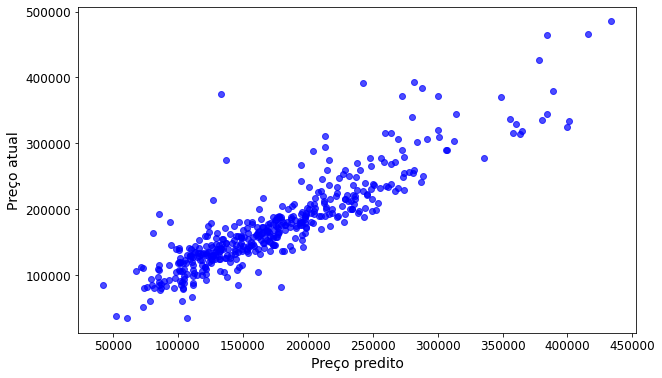

In [115]:
plt.figure(figsize = [10, 6])

plt.scatter(previsoes, y_valid, alpha=.7, color='b')
plt.xlabel("Preço predito", fontsize = 14, color = "black")
plt.ylabel("Preço atual", fontsize = 14, color = "black")
plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")

plt.show()

In [118]:
previsoes_teste_exp = reg.predict(teste1)

#--- Selecionando o ID

id_teste = teste["Id"]

subm = pd.DataFrame()

subm["Id"] = id_teste
subm["SalePrice"] = previsoes_teste_exp

subm.to_csv("subm2.csv", index = False)

subm.head()

,Id,SalePrice
0,1461,204704.691245
1,1462,159031.220633
2,1463,216376.072321
3,1464,175228.309196
4,1465,288778.238794


---

